# Luminosity

In [1]:
from spice.models import IcosphereModel
from spice.spectrum import simulate_spectrum
import astropy.units as u
import jax.numpy as jnp
from transformer_payne import Blackbody
import matplotlib.pyplot as plt

from jax import config
config.update('jax_platform_name', 'cpu')
config.update("jax_enable_x64", True)

PHOEBE: passband "Bolometric:900-40000" has a newer version available.  Run phoebe.list_passband_online_history("Bolometric:900-40000") to get a list of available changes and phoebe.update_passband("Bolometric:900-40000") or phoebe.update_all_passbands() to update.
PHOEBE: passband "Johnson:V" has a newer version available.  Run phoebe.list_passband_online_history("Johnson:V") to get a list of available changes and phoebe.update_passband("Johnson:V") or phoebe.update_all_passbands() to update.
PHOEBE: passband "Stromgren:b" has a newer version available.  Run phoebe.list_passband_online_history("Stromgren:b") to get a list of available changes and phoebe.update_passband("Stromgren:b") or phoebe.update_all_passbands() to update.


/Users/majajablonska/miniconda/envs/tp-env/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Let's use a simple, blackbody model just for the testing purposes, alogside with a solar-like model.

In [2]:
bb = Blackbody()
model = IcosphereModel.construct(1000, u.solRad.to(u.cm), u.solMass.to(u.kg), bb.solar_parameters, bb.parameter_names)

/Users/majajablonska/Documents/Workspace/stellar-mesh-integration/src/spice/models/mesh_model.py:202: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


To test the bolometric luminosity value, let's choose a wide range of wavelengths.

In [3]:
vws = jnp.linspace(1000., 30000., 1000)

Text(0, 0.5, 'Intensity [erg/s/cm$^3$]')

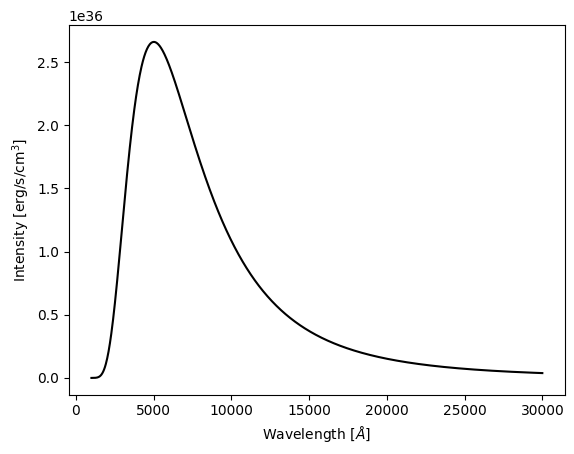

In [4]:
i_bb = simulate_spectrum(bb.intensity, model, jnp.log10(vws), chunk_size=1000)
plt.plot(vws, i_bb[:, 0], color='black')
plt.gca().set_xlabel('Wavelength [$\\AA$]')
plt.gca().set_ylabel('Intensity [erg/s/cm$^3$]')

# Filters

Let's use the ```Filter``` subclasses to check the passband luminosities.

In [5]:
from spice.spectrum.filter import BesselB, BesselI, GaiaG

In [6]:
bessel_b = BesselB()
bessel_i = BesselI()
gaia_g = GaiaG()

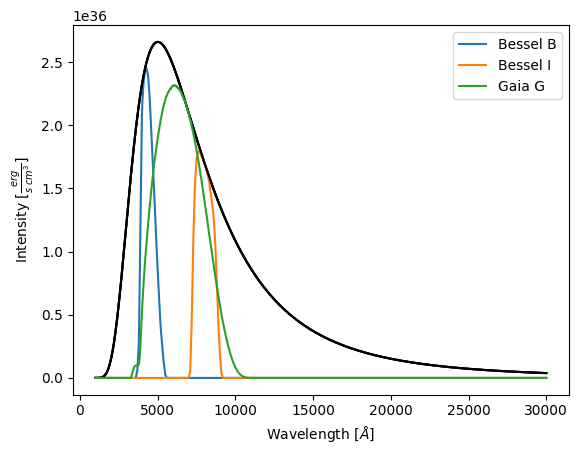

In [7]:
bessel_b.plot_filter_responses_for_wavelengths(vws, i_bb[:, 0])
bessel_i.plot_filter_responses_for_wavelengths(vws, i_bb[:, 0])
gaia_g.plot_filter_responses_for_wavelengths(vws, i_bb[:, 0])

The passband luminosities can be calculated using the ```AB_passband_luminosity``` function. Make sure to divide the observed luminosity by the distance first!

In [8]:
from spice.spectrum.spectrum import AB_passband_luminosity

In [9]:
solar_apparent_mag_B = AB_passband_luminosity(bessel_b, vws, i_bb[:, 0], distance=u.AU.to(u.cm))
solar_apparent_mag_I = AB_passband_luminosity(bessel_i, vws, i_bb[:, 0], distance=u.AU.to(u.cm))
solar_apparent_mag_G = AB_passband_luminosity(gaia_g, vws, i_bb[:, 0], distance=u.AU.to(u.cm))

print("Apparent magnitude of the Sun")
print("Bessel B:\t", solar_apparent_mag_B, "mag")
print("Bessel I:\t", solar_apparent_mag_I, "mag")
print("Gaia G:\t\t", solar_apparent_mag_G, "mag")

Apparent magnitude of the Sun
Bessel B:	 -25.75156738955026 mag
Bessel I:	 -26.625963108907666 mag
Gaia G:		 -26.3936140452507 mag


# Bolometric luminosity of the Sun

The bolometric luminosity of the Sun is the energy that is outputted by the whole Sun. To calculate that, we need to obtain the total flux first.

In [10]:
from spice.spectrum import luminosity, absolute_bol_luminosity

In [11]:
solar_luminosity = luminosity(bb.flux, model, vws)
print("Sun's bolometric luminosity:", solar_luminosity, "erg/s")
print("Sun's absolute bolometric luminosity:", absolute_bol_luminosity(solar_luminosity), "mag")

Sun's bolometric luminosity: 3.759724004167405e+33 erg/s
Sun's absolute bolometric luminosity: 4.759510087060199 mag
